In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

## Reading training data and test data

In [2]:
df_train = pd.read_csv('database/train.csv', low_memory=False, parse_dates=['date'],
                   date_parser = lambda dt:pd.to_datetime(dt, format='%Y-%m-%d'),skiprows=range(1, 124035460),
                   converters={'unit_sales': lambda u: float(u) if float(u) > 0 else 0})
df_test = pd.read_csv('database/test.csv',low_memory=False, parse_dates=['date'], 
                   date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

In [3]:
len(df_train)

1461581

In [4]:
df_train['Set'] = 1
df_test['Set'] = 0

In [5]:
frames = [df_train, df_test]
df = pd.concat(frames)

In [6]:
features_y = ['SalesLog']

In [7]:
#df['unit_sales'].describe()

count    1.461581e+06
mean     7.830799e+00
std      2.160031e+01
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      4.908000e+03
Name: unit_sales, dtype: float64

In [8]:
df.loc[df['Set']==1, 'SalesLog'] = np.log1p(df.loc[df['Set'] == 1]['unit_sales'])

In [9]:
var_name = 'date'
df[var_name + 'Day'] = pd.Index(df[var_name]).day
df[var_name + 'Week'] = pd.Index(df[var_name]).week
df[var_name + 'Month'] = pd.Index(df[var_name]).month
df[var_name + 'Year'] = pd.Index(df[var_name]).year
df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear
df[var_name + 'DayOfWeek'] = pd.Index(df[var_name]).dayofweek

df[var_name + 'Day'] = df[var_name + 'Day'].fillna(0)
df[var_name + 'Week'] = df[var_name + 'Week'].fillna(0)
df[var_name + 'Month'] = df[var_name + 'Month'].fillna(0)
df[var_name + 'Year'] = df[var_name + 'Year'].fillna(0)
df[var_name + 'DayOfYear'] = df[var_name + 'DayOfYear'].fillna(0)
df[var_name + 'DayOfWeek'] = df[var_name + 'DayOfWeek'].fillna(0)

In [10]:
features_x = []

In [11]:
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')
features_x.append(var_name + 'DayOfWeek')

In [12]:
features_x

['dateDay',
 'dateWeek',
 'dateMonth',
 'dateYear',
 'dateDayOfYear',
 'dateDayOfWeek']

In [13]:
df['DateInt'] = df['date'].astype(np.int64)

In [14]:
#df.head()

## Setting seed

In [15]:
seed = 42

## Reading oil data, and fill the empty data to the next day

In [16]:
df_oil = pd.read_csv('database/oil.csv',parse_dates=['date'],
                     date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

In [17]:
#df_oil.head()

In [18]:
def FillOilNan(window_size, lenoil, oilprice):
    mean_list = []
    for everyday in null_day:
        backward_index = everyday - window_size
        forward_index = everyday + window_size
        price_list = []
        if backward_index < 0:
            backward_index = 0
        if forward_index > lenoil:
            forward_index = lenoil - 1
        neighbor_data = oilprice[backward_index : forward_index]
        for each in neighbor_data:
            if each > 0:
                price_list.append(each)
        mean_list.append(np.mean(price_list))
    
    return mean_list    

In [19]:
null_day = np.array(df_oil.loc[df_oil['dcoilwtico'].isnull()].index)
price = np.array(df_oil['dcoilwtico'])
mean_price = FillOilNan(2,len(df_oil),price)
df_oil['dcoilwtico'][np.isnan(df_oil['dcoilwtico'])] = mean_price

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### merge the oil data to the frame

In [20]:
df = pd.merge(df, df_oil, how='left', on=['date'])

In [21]:
#df.tail()

In [22]:
features_x.append('dcoilwtico')

In [23]:
features_x

['dateDay',
 'dateWeek',
 'dateMonth',
 'dateYear',
 'dateDayOfYear',
 'dateDayOfWeek',
 'dcoilwtico']

## Reading stores' data

In [24]:
df_store = pd.read_csv('database/stores.csv')

In [25]:
#df_store.head()

In [26]:
type_dummies = pd.get_dummies(df_store['type'], prefix='type')
city_dummies = pd.get_dummies(df_store['city'],prefix='city')
state_dummies = pd.get_dummies(df_store['state'], prefix='state')

In [27]:
df_store = df_store.join(type_dummies)
df_store = df_store.join(city_dummies)
df_store = df_store.join(state_dummies)


,store_nbr,city,state,type,cluster,type_A,type_B,type_C,type_D,type_E,...,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua
0,1,Quito,Pichincha,D,13,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,2,Quito,Pichincha,D,13,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,3,Quito,Pichincha,D,8,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,4,Quito,Pichincha,D,9,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
#df_store.head()

In [29]:
type_features = list(type_dummies.columns)
city_features = list(city_dummies.columns)
state_features = list(state_dummies.columns)

In [30]:
feature_store = []
feature_store.extend(type_features)
feature_store.extend(city_features)
feature_store.extend(state_features)
feature_store.append('cluster')
feature_store.append('store_nbr')


In [31]:
features_x.extend(feature_store)

In [32]:
df = pd.merge(df, df_store[feature_store], how='left',on=['store_nbr'])

In [33]:
len(features_x)

52

In [34]:
#df.head()

## Reading items' data

In [35]:
df_item = pd.read_csv('database/items.csv')
#df_item.head()

In [36]:
df_item['weight'] = np.array(df_item['perishable']) * 0.25 + 1.0

In [37]:
family_dummies = pd.get_dummies(df_item['family'], prefix='family')
df_item = df_item.join(family_dummies)

In [38]:
family_features = family_dummies.columns
feature_item = []
feature_item.extend(family_features)
feature_item.append('item_nbr')
feature_item.append('class')
feature_item.append('perishable')
feature_item.append('weight')
features_x.extend(feature_item)


In [39]:
len(features_x)

89

In [40]:
df = pd.merge(df, df_item[feature_item], how='left', on=['item_nbr'])

## Reading transactions data

In [41]:
df_transaction = pd.read_csv('database/transactions.csv', parse_dates=['date'],
                             date_parser= lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'))

In [42]:
#df_transaction.head()

In [43]:
df = pd.merge(df, df_transaction, how='left', on=['date', 'store_nbr'])

In [44]:
feature_transaction = ['transactions']
features_x.extend(feature_transaction)

In [45]:
len(features_x)

90

## Reading holiday_events

In [46]:
df_holiday = pd.read_csv('database/holidays_events.csv', parse_dates=['date'], 
                         date_parser= lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'))

In [47]:
#df_holiday.head()

In [48]:
type_dummies = pd.get_dummies(df_holiday['type'], prefix='type')
locale_dummies = pd.get_dummies(df_holiday['locale'], prefix='locale')
locale_name_dummies = pd.get_dummies(df_holiday['locale_name'], prefix='locale_name')
transferred_dummies = pd.get_dummies(df_holiday['transferred'], prefix='transferred')

In [49]:
type_features = list(type_dummies.columns)
locale_features = list(locale_dummies.columns)
locale_name_features = list(locale_name_dummies.columns)
transferred_features = list(transferred_dummies.columns)
feature_holiday = []
feature_holiday.extend(type_features)
feature_holiday.extend(locale_features)
feature_holiday.extend(locale_name_features)
feature_holiday.extend(transferred_features)
feature_holiday.append('date')
features_x.extend(feature_holiday)

In [50]:
df_holiday = df_holiday.join(type_dummies)
df_holiday = df_holiday.join(locale_dummies)
df_holiday = df_holiday.join(locale_name_dummies)
df_holiday = df_holiday.join(transferred_dummies)
df = pd.merge(df, df_holiday[feature_holiday], how='left', on=['date'])

In [51]:
len(features_x)

126

## 数据清洗

In [52]:
#features_x

In [53]:
df['onpromotion'] = df['onpromotion'].map({False:0,True:1}).astype(int)
features_x.append('onpromotion')

In [54]:
#df.head()

In [57]:
df = df.fillna(0)

In [58]:
#df.head()

,Set,date,id,item_nbr,onpromotion,store_nbr,unit_sales,SalesLog,dateDay,dateWeek,...,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas,transferred_False,transferred_True
0,1,2017-08-02,124035459,96995,0,1,1.0,0.693147,2,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2017-08-02,124035460,103520,0,1,1.0,0.693147,2,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2017-08-02,124035461,103665,0,1,2.0,1.098612,2,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2017-08-02,124035462,105574,0,1,8.0,2.197225,2,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2017-08-02,124035463,105575,0,1,8.0,2.197225,2,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
#df.tail()

,Set,date,id,item_nbr,onpromotion,store_nbr,unit_sales,SalesLog,dateDay,dateWeek,...,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas,transferred_False,transferred_True
4832040,0,2017-08-31,128867499,2132163,0,54,0.0,0.0,31,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4832041,0,2017-08-31,128867500,2132318,0,54,0.0,0.0,31,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4832042,0,2017-08-31,128867501,2132945,0,54,0.0,0.0,31,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4832043,0,2017-08-31,128867502,2132957,0,54,0.0,0.0,31,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4832044,0,2017-08-31,128867503,2134244,0,54,0.0,0.0,31,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Split and train

In [60]:
from sklearn.cross_validation import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[df['Set'] == 1][features_x], 
                                                    df.loc[df['Set'] == 1][features_y], 
                                                   test_size = 0.15, random_state = seed)

In [62]:
class NWRMSLE:
    def set_weights(self, weights):
        self.weights = weights

    def _NWRMSLE(self, a, p, w):
        a = np.array(a)
        a[a < 0.0]=0.0
        p = np.array(p)
        p[p < 0.0]=0.0
        w = np.array(w)
        weighted_errors = np.dot(np.square(np.log1p(p) - np.log1p(a)), np.transpose(w))
        weights_sum = np.sum(w)
        return math.sqrt(weighted_errors/weights_sum)

    def NWRMSLE_xgb(self, preds, dtrain):
        labels = dtrain.get_label()
        NWRMSLE_score = self._NWRMSLE(labels, preds, self.weights)
        return [('NWRMSLE', NWRMSLE_score)]

In [63]:
X_test_weight = X_test['weight']
eval_metric = NWRMSLE()
eval_metric.set_weights(X_test_weight)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4832045 entries, 0 to 4832044
Columns: 132 entries, Set to transferred_True
dtypes: datetime64[ns](1), float64(40), int32(1), int64(14), uint8(76)
memory usage: 2.4 GB


In [68]:
#del X_train['weight']
#del X_test['weight']
del X_train['date']
del X_test['date']

In [69]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [70]:
num_round = 20000
evallist = [(dtest, 'test')]

param = {'bst:max_depth':20,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1,
         'objective':'reg:linear',
         'nthread':6,
         'eval_metric':'rmse',
         'seed':seed}
plst = param.items()

In [72]:
import math
bst = xgb.train(plst, dtrain, num_round, evallist, feval=eval_metric.NWRMSLE_xgb, verbose_eval=250, early_stopping_rounds=250)

[0]	test-rmse:1.16656	test-NWRMSLE:0.435898
Multiple eval metrics have been passed: 'test-NWRMSLE' will be used for early stopping.

Will train until test-NWRMSLE hasn't improved in 250 rounds.
[250]	test-rmse:0.603967	test-NWRMSLE:0.227899
[500]	test-rmse:0.569342	test-NWRMSLE:0.217017
[750]	test-rmse:0.552082	test-NWRMSLE:0.211533
[1000]	test-rmse:0.542695	test-NWRMSLE:0.208596
[1250]	test-rmse:0.536565	test-NWRMSLE:0.206705
[1500]	test-rmse:0.531418	test-NWRMSLE:0.205104
[1750]	test-rmse:0.528018	test-NWRMSLE:0.204073
[2000]	test-rmse:0.524972	test-NWRMSLE:0.203153
[2250]	test-rmse:0.522461	test-NWRMSLE:0.202363
[2500]	test-rmse:0.520422	test-NWRMSLE:0.201779
[2750]	test-rmse:0.518716	test-NWRMSLE:0.201309
[3000]	test-rmse:0.517069	test-NWRMSLE:0.200818
[3250]	test-rmse:0.516145	test-NWRMSLE:0.200554
[3500]	test-rmse:0.515147	test-NWRMSLE:0.200288
[3750]	test-rmse:0.514196	test-NWRMSLE:0.200008
[4000]	test-rmse:0.513361	test-NWRMSLE:0.199795
[4250]	test-rmse:0.51267	test-NWRMSLE:0.1

In [84]:
import pylab
import csv
import datetime
import math
import re
import time
import random
import os
np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)
%matplotlib inline

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000000000C384828>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost-0.6-py3.6.egg\xgboost\core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


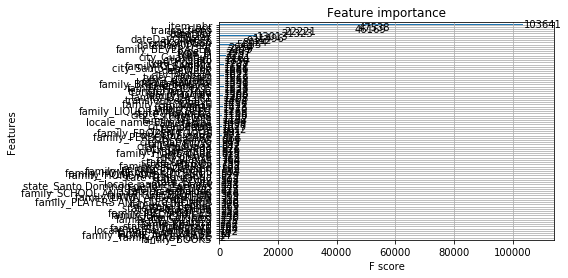

In [85]:
xgb.plot_importance(bst)

In [74]:
X_submit = df.loc[df['Set'] == 0]

In [75]:
X_submit_weight = X_submit['weight']
del X_submit['weight']

In [76]:
features_x.remove('weight')

In [78]:
features_x.remove('date')

In [79]:
dsubmit = xgb.DMatrix(X_submit[features_x])

In [80]:
ypred_bst = bst.predict(dsubmit)

In [81]:
df_ypred = X_submit['id'].reset_index()

In [ ]:
del df_ypred['index']
df_ypred['id'] = df_ypred['id'].astype('int')

df_ypred['unit_sales'] = (np.exp(ypred_bst) - 1) * 0.985
df_ypred['unit_sales'] = df_ypred['unit_sales'].apply(lambda dt: dt if dt > 0 else 0)


df_ypred.sort_values('id', inplace=True)
df_ypred[['id', 'unit_sales']].to_csv('submit5.csv', index=False)